<a href="https://colab.research.google.com/github/Hilly12/prifair/blob/main/PrivacyFairnessMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Privacy and Fairness MNIST

## Setting Up

In [1]:
!pip install git+https://github.com/Hilly12/prifair.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Hilly12/prifair.git to /tmp/pip-req-build-mzhvfn56
  Running command git clone -q https://github.com/Hilly12/prifair.git /tmp/pip-req-build-mzhvfn56
     |████████████████████████████████| 175 kB 13.9 MB/s 
  Created wheel for prifair: filename=prifair-0.0.0-py3-none-any.whl size=15313 sha256=aaf76295f6e7dc53d7397da2611e918a2b04805a4faee2c7207ce929b9399e0a
  Stored in directory: /tmp/pip-ephem-wheel-cache-jf900ova/wheels/b2/ce/e6/42357e741db5b6d515a7748b4de38b168f6e36e3b6b6d3a1a5
Successfully built prifair


In [2]:
import os
import json
import numpy as np
import pandas as pd
import prifair as pf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from google.colab import drive
from collections import defaultdict
from opacus import PrivacyEngine, GradSampleModule
from opacus.accountants import RDPAccountant
from opacus.accountants.utils import get_noise_multiplier
from opacus.data_loader import DPDataLoader
from opacus.optimizers import DPOptimizer
from opacus.privacy_engine import forbid_accumulation_hook
from opacus.validators import ModuleValidator
from opacus.utils.batch_memory_manager import BatchMemoryManager
from scipy.stats import wasserstein_distance
from sklearn.metrics import confusion_matrix
from torch.utils.data import Sampler
from torchvision import datasets, transforms, models
from tqdm import tqdm
from typing import List, Sequence

from IPython.display import clear_output
from IPython.utils import io 

np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Loading

In [3]:
data_root = "data/mnist"
unlabelled_data_root = "data/emnist"

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


train_data = datasets.MNIST(data_root, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(data_root, train=False, transform=transforms.ToTensor())
unlabelled_data = datasets.EMNIST(unlabelled_data_root, split="digits", train=True, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/emnist/EMNIST/raw/gzip.zip to data/emnist/EMNIST/raw


In [4]:
downsampled_num = 7
n_downsampled = 300

all_idxs = np.arange(len(train_data))
num_idxs = all_idxs[train_data.targets == downsampled_num]
downsampled_idxs = np.random.choice(num_idxs, n_downsampled, replace=False)
rem_idxs = all_idxs[train_data.targets != downsampled_num]

idxs = np.concatenate((rem_idxs, downsampled_idxs))
np.random.shuffle(idxs)
val_split = 0

split_pt = int(val_split * len(idxs))
downsampled_train_data = torch.utils.data.Subset(train_data, idxs[split_pt:])
downsampled_val_data = torch.utils.data.Subset(train_data, idxs[:split_pt])

In [5]:
n_student = 30000
idxs = np.random.permutation(len(unlabelled_data))[:n_student]
student_subset = torch.utils.data.Subset(unlabelled_data, idxs)

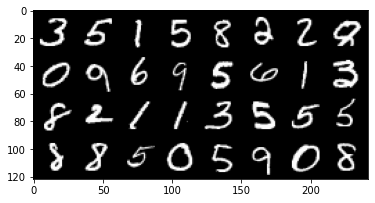

In [6]:
logical_batch_size = 512
max_physical_batch_size = 256

train_loader = torch.utils.data.DataLoader(
    downsampled_train_data,
    batch_size=logical_batch_size,
    shuffle=False
)
val_loader = torch.utils.data.DataLoader(
    downsampled_val_data,
    batch_size=logical_batch_size,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=logical_batch_size,
    shuffle=False
)
student_loader = torch.utils.data.DataLoader(
    student_subset,
    batch_size=logical_batch_size,
    shuffle=False
)

imgs, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(imgs[:32])
plt.figure()
show(grid)

## Models

In [7]:
class VanillaCNN(nn.Module):
    def __init__(self):
        super(VanillaCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=(32 * 7 * 7), out_features=100),
            nn.Linear(in_features=100, out_features=10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.cnn(x)


class VanillaVAE(nn.Module):
    def __init__(self, latent_dim):
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )

        self.mu_layer = nn.Linear(in_features=(32 * 7 * 7), out_features=latent_dim)
        self.logvar_layer = nn.Linear(in_features=(32 * 7 * 7), out_features=latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=(32 * 7 * 7)),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        out = self.encoder(x)
        mu = self.mu_layer(out)
        logvar = self.logvar_layer(out)
        return mu, logvar
    
    def reparametrize(self, mu, logvar):
        eps = torch.randn_like(mu)
        return mu + eps * torch.exp(logvar * 0.5)

    def decode(self, z):
        return self.decoder(z)

    def loss_function(self, recon_x, x, mu, logvar, beta):
        recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
        kl_div = 0.5 * torch.sum(torch.exp(logvar) + mu.pow(2) - 1 - logvar)
        return recon_loss + beta * kl_div
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

## Training

### Latent Space Analysis

#### Train VAE

Total number of parameters is: 93953


100%|██████████| 106/106 [00:04<00:00, 21.83it/s]


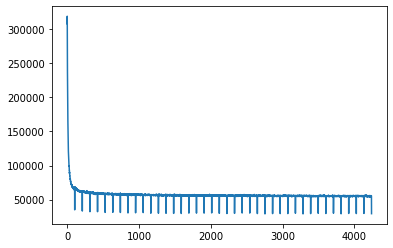

In [8]:
num_epochs = 40
learning_rate = 5e-3
latent_dim = 16
beta = 1

vae_train_loader = pf.data.WeightedDataLoader(train_loader)
# vae_train_loader = pf.data.WeightedDataLoader(student_loader)

vae = VanillaVAE(latent_dim).to(device)
params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

vae.train()
losses = []

for epoch in range(num_epochs):
    for batch in tqdm(vae_train_loader):
        optimizer.zero_grad()
        
        x = batch[0].to(device)
        recon_x, mu, logvar = vae(x)

        loss = vae.loss_function(recon_x, x, mu, logvar, beta)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    weights = pf.core.latent_reweigh(vae_train_loader, vae)
    vae_train_loader.update_weights(weights)

plt.plot(losses)
plt.show()

#### Visualize Latent Space

In [9]:
!git clone -q https://github.com/afspies/icl_dl_cw2_utils
clear_output()

from icl_dl_cw2_utils.utils.plotting import plot_tsne
from sklearn.manifold import TSNE

In [10]:
zs = []
for imgs, _ in train_loader:
    mu, logvar = vae.encode(imgs.to(device))
    z = vae.reparametrize(mu, logvar)
    zs.append(z.cpu().detach().numpy())

z = np.concatenate(zs)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
z_embedded = tsne.fit_transform(z)

plot_tsne(z_embedded, train_loader, num_points=1000, darkmode=False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 54035 samples in 0.001s...
[t-SNE] Computed neighbors for 54035 samples in 56.300s...
[t-SNE] Computed conditional probabilities for sample 1000 / 54035
[t-SNE] Computed conditional probabilities for sample 2000 / 54035
[t-SNE] Computed conditional probabilities for sample 3000 / 54035
[t-SNE] Computed conditional probabilities for sample 4000 / 54035
[t-SNE] Computed conditional probabilities for sample 5000 / 54035
[t-SNE] Computed conditional probabilities for sample 6000 / 54035
[t-SNE] Computed conditional probabilities for sample 7000 / 54035
[t-SNE] Computed conditional probabilities for sample 8000 / 54035
[t-SNE] Computed conditional probabilities for sample 9000 / 54035
[t-SNE] Computed conditional probabilities for sample 10000 / 54035
[t-SNE] Computed conditional probabilities for sample 11000 / 54035
[t-SNE] Computed conditional probabilities for sample 12000 / 54035
[t-SNE] Computed conditional probabilities for s

alt.HConcatChart(...)

#### Analysis

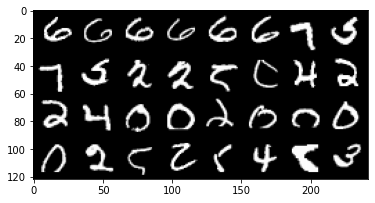

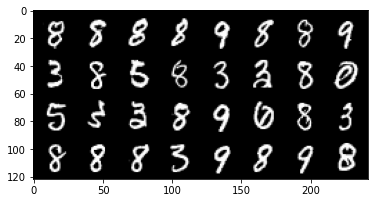

In [11]:
vae.eval()

weights = pf.core.latent_reweigh(train_loader, vae)

argsort = weights.argsort()
top = argsort[-32:]
bottom = argsort[:32]

input = torch.stack(tuple(zip(*train_loader.dataset))[0])[top]
img = torchvision.utils.make_grid(input)
plt.figure()
show(img)

input = torch.stack(tuple(zip(*train_loader.dataset))[0])[bottom]
img = torchvision.utils.make_grid(input)
plt.figure()
show(img)

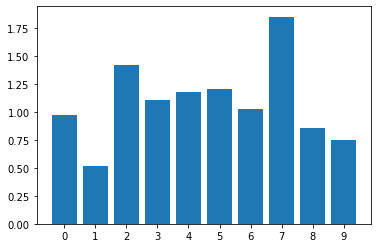

In [12]:
labels = np.array(tuple(zip(*train_loader.dataset))[1])
relative_weights = []
for i in range(10):
    relative_weights.append(weights[labels == i].mean() * len(train_loader.dataset))

plt.bar(np.arange(10), relative_weights)
plt.xticks(np.arange(10))
plt.show()

100%|██████████| 106/106 [00:04<00:00, 25.77it/s]


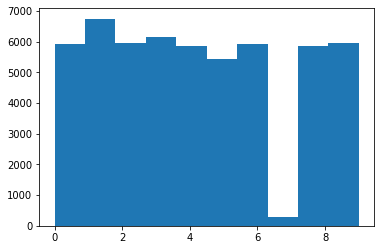

In [13]:
seen_labels = []
for imgs, labels in tqdm(train_loader):
    seen_labels.append(labels)

plt.hist(np.concatenate(seen_labels))
plt.show()

100%|██████████| 106/106 [00:04<00:00, 24.91it/s]


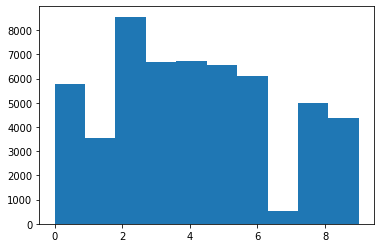

In [14]:
batch_sampler = pf.data.NonUniformPoissonSampler(
    weights=weights,
    num_samples=len(train_loader.dataset),
    sample_rate=(1 / len(train_loader))
)

fair_loader = pf.utils._data_loader_with_batch_sampler(train_loader, batch_sampler)

seen_labels = []
for imgs, labels in tqdm(fair_loader):
    seen_labels.append(labels)

plt.hist(np.concatenate(seen_labels))
plt.show()

### Training Vanilla

In [15]:
model_vanilla, metrics_vanilla = pf.training.train_vanilla(
    train_loader=train_loader,
    val_loader=val_loader,
    model_class=VanillaCNN,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    epochs=5
)

100%|██████████| 106/106 [00:04<00:00, 22.61it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 1 Train Loss: 0.26 Train Acc@1: 0.92 Val Loss: nan Val Acc@1: nan 


100%|██████████| 106/106 [00:04<00:00, 23.38it/s]


Epoch: 2 Train Loss: 0.08 Train Acc@1: 0.98 Val Loss: nan Val Acc@1: nan 


100%|██████████| 106/106 [00:04<00:00, 22.80it/s]


Epoch: 3 Train Loss: 0.04 Train Acc@1: 0.99 Val Loss: nan Val Acc@1: nan 


100%|██████████| 106/106 [00:04<00:00, 22.44it/s]


Epoch: 4 Train Loss: 0.03 Train Acc@1: 0.99 Val Loss: nan Val Acc@1: nan 


100%|██████████| 106/106 [00:04<00:00, 23.20it/s]

Epoch: 5 Train Loss: 0.12 Train Acc@1: 0.98 Val Loss: nan Val Acc@1: nan 


In [16]:
pf.utils.evaluate_model(model_vanilla, test_loader);

Test Accuracy: 96.740000


### Train DPSGD

In [17]:
model_dpsgd, metrics_dpsgd = pf.training.train_dpsgd(
    train_loader=train_loader,
    val_loader=val_loader,
    model_class=VanillaCNN,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    target_epsilon=1,
    target_delta=1e-5,
    max_grad_norm=1.2,
    epochs=5,
    max_physical_batch_size=max_physical_batch_size
)

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:115: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.7/dist-packages/opacus/accountants/analysis/rdp.py:333: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."
  0%|          | 0/211 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing so

Epoch: 1 Train Loss: 0.65 Train Acc@1: 0.82 Val Loss: nan Val Acc@1: nan (ε = 0.71, δ = 1e-05) 


256it [00:06, 37.54it/s]


Epoch: 2 Train Loss: 0.34 Train Acc@1: 0.92 Val Loss: nan Val Acc@1: nan (ε = 0.80, δ = 1e-05) 


263it [00:06, 38.93it/s]


Epoch: 3 Train Loss: 0.27 Train Acc@1: 0.93 Val Loss: nan Val Acc@1: nan (ε = 0.86, δ = 1e-05) 


254it [00:06, 39.59it/s]


Epoch: 4 Train Loss: 0.23 Train Acc@1: 0.94 Val Loss: nan Val Acc@1: nan (ε = 0.93, δ = 1e-05) 


260it [00:06, 39.80it/s]

Epoch: 5 Train Loss: 0.22 Train Acc@1: 0.95 Val Loss: nan Val Acc@1: nan (ε = 1.00, δ = 1e-05) 


In [18]:
pf.utils.evaluate_model(model_dpsgd, test_loader);

Test Accuracy: 89.390000


### Training Latent Reweighed DPSGD 

In [19]:
model_dpsgdw, metrics_dpsgdw = pf.training.train_dpsgd_weighted(
    train_loader=train_loader,
    val_loader=None,
    model_class=VanillaCNN,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    target_epsilon=1,
    target_delta=1e-5,
    max_grad_norm=1.2,
    epochs=5,
    max_physical_batch_size=max_physical_batch_size,
    weighting="latent",
    vae=vae,
)

Reweighing...


/usr/local/lib/python3.7/dist-packages/opacus/accountants/analysis/rdp.py:333: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."


Training Model...


  0%|          | 0/211 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
261it [00:06, 39.97it/s]


Epoch: 1 Train Loss: 1.23 Train Acc@1: 0.62 (ε = 0.12, δ = 1e-05) 


253it [00:06, 39.04it/s]


Epoch: 2 Train Loss: 0.56 Train Acc@1: 0.82 (ε = 0.13, δ = 1e-05) 


262it [00:06, 39.52it/s]


Epoch: 3 Train Loss: 0.47 Train Acc@1: 0.86 (ε = 0.15, δ = 1e-05) 


254it [00:06, 38.42it/s]


Epoch: 4 Train Loss: 0.42 Train Acc@1: 0.88 (ε = 0.16, δ = 1e-05) 


258it [00:06, 39.10it/s]

Epoch: 5 Train Loss: 0.40 Train Acc@1: 0.89 (ε = 0.17, δ = 1e-05) 


In [20]:
pf.utils.evaluate_model(model_dpsgdw, test_loader);

Test Accuracy: 84.900000


### Training Reweighed DPSGD

In [21]:
model_dpsgdis, metrics_dpsgdis = pf.training.train_dpsgd_weighted(
    train_loader=train_loader,
    val_loader=None,
    model_class=VanillaCNN,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    target_epsilon=1,
    target_delta=1e-5,
    max_grad_norm=1.2,
    epochs=5,
    max_physical_batch_size=max_physical_batch_size,
    weighting="sensitive_attr",
    labels=np.array(tuple(zip(*train_loader.dataset))[1])
)

Reweighing...
Training Model...


  0%|          | 0/211 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
251it [00:06, 38.83it/s]
/usr/local/lib/python3.7/dist-packages/opacus/accountants/analysis/rdp.py:333: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."


Epoch: 1 Train Loss: 1.95 Train Acc@1: 0.42 (ε = 0.10, δ = 1e-05) 


250it [00:06, 38.36it/s]


Epoch: 2 Train Loss: 1.21 Train Acc@1: 0.67 (ε = 0.11, δ = 1e-05) 


258it [00:06, 39.32it/s]


Epoch: 3 Train Loss: 0.82 Train Acc@1: 0.75 (ε = 0.11, δ = 1e-05) 


260it [00:06, 39.12it/s]


Epoch: 4 Train Loss: 0.62 Train Acc@1: 0.80 (ε = 0.11, δ = 1e-05) 


258it [00:06, 38.87it/s]

Epoch: 5 Train Loss: 0.52 Train Acc@1: 0.84 (ε = 0.11, δ = 1e-05) 


In [22]:
pf.utils.evaluate_model(model_dpsgdis, test_loader);

Test Accuracy: 85.510000


### Training DPSGD-F

In [25]:
model_dpsgdf, metrics_dpsgdf = pf.training.train_dpsgdf(
    train_loader=train_loader,
    val_loader=None,
    model_class=VanillaCNN,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    target_epsilon=1,
    target_delta=1e-5,
    base_clipping_threshold=1.2,
    epochs=5,
    group_labels=torch.LongTensor(tuple(zip(*train_loader.dataset))[1]),
    max_physical_batch_size=max_physical_batch_size
)

/usr/local/lib/python3.7/dist-packages/opacus/accountants/analysis/rdp.py:333: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."


Training Model...


  0%|          | 0/106 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
263it [00:07, 34.31it/s]


Epoch: 1 Train Loss: 0.61 Train Acc@1: 0.82 (ε = 0.71, δ = 1e-05) 


249it [00:07, 33.58it/s]


Epoch: 2 Train Loss: 0.31 Train Acc@1: 0.91 (ε = 0.80, δ = 1e-05) 


272it [00:07, 35.00it/s]


Epoch: 3 Train Loss: 0.28 Train Acc@1: 0.93 (ε = 0.86, δ = 1e-05) 


261it [00:07, 34.60it/s]


Epoch: 4 Train Loss: 0.25 Train Acc@1: 0.93 (ε = 0.93, δ = 1e-05) 


251it [00:07, 31.91it/s]

Epoch: 5 Train Loss: 0.25 Train Acc@1: 0.93 (ε = 1.00, δ = 1e-05) 


In [26]:
pf.utils.evaluate_model(model_dpsgdf, test_loader);

Test Accuracy: 92.220000


### Training PATE


In [23]:
model_pate, metrics_pate = pf.training.train_pate(
    train_loader=train_loader,
    val_loader=None,
    student_loader=student_loader,
    model_class=VanillaCNN,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    n_teachers=4,
    target_epsilon=1,
    target_delta=1e-5,
    epochs=5,
)

Training 4 Teacher Models...


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Teacher Model: 1 Loss: 0.05 Acc@1: 98.51  


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Teacher Model: 2 Loss: 0.05 Acc@1: 98.46  


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Teacher Model: 3 Loss: 0.05 Acc@1: 98.57  


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Teacher Model: 4 Loss: 0.05 Acc@1: 98.59  
Aggregating Teachers...


100%|██████████| 4/4 [00:11<00:00,  2.86s/it]


Training Student Model...


100%|██████████| 59/59 [00:02<00:00, 23.27it/s]


Epoch: 1 Train Loss: 0.78 Train Acc@1: 0.75 


100%|██████████| 59/59 [00:02<00:00, 23.53it/s]


Epoch: 2 Train Loss: 0.53 Train Acc@1: 0.83 


100%|██████████| 59/59 [00:02<00:00, 23.26it/s]


Epoch: 3 Train Loss: 0.46 Train Acc@1: 0.86 


100%|██████████| 59/59 [00:02<00:00, 21.27it/s]


Epoch: 4 Train Loss: 0.42 Train Acc@1: 0.87 


100%|██████████| 59/59 [00:02<00:00, 23.26it/s]

Epoch: 5 Train Loss: 0.40 Train Acc@1: 0.88 


In [24]:
pf.utils.evaluate_model(model_pate, test_loader);

Test Accuracy: 76.320000


### Training SF-T-PATE with Reweighing

In [37]:
model_sftpate, metrics_sftpate = pf.training.train_reweighed_sftpate(
    train_loader=train_loader,
    val_loader=None,
    student_loader=student_loader,
    model_class=VanillaCNN,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    n_teachers=4,
    target_epsilon=1,
    target_delta=1e-5,
    epochs=5,
    weights=pf.core.reweigh(tuple(zip(*train_loader.dataset))[1])
)

Training 4 Teacher Models...


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Teacher Model: 1 Loss: 0.04 Acc@1: 98.92  


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Teacher Model: 2 Loss: 0.05 Acc@1: 98.69  


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Teacher Model: 3 Loss: 0.04 Acc@1: 98.87  


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Teacher Model: 4 Loss: 0.05 Acc@1: 98.53  
Aggregating Teachers...


100%|██████████| 4/4 [00:11<00:00,  2.84s/it]


Training Student Model...


100%|██████████| 59/59 [00:02<00:00, 22.97it/s]


Epoch: 1 Train Loss: 0.88 Train Acc@1: 0.72 


100%|██████████| 59/59 [00:02<00:00, 23.43it/s]


Epoch: 2 Train Loss: 0.56 Train Acc@1: 0.82 


100%|██████████| 59/59 [00:02<00:00, 22.38it/s]


Epoch: 3 Train Loss: 0.49 Train Acc@1: 0.84 


100%|██████████| 59/59 [00:02<00:00, 21.85it/s]


Epoch: 4 Train Loss: 0.45 Train Acc@1: 0.86 


100%|██████████| 59/59 [00:02<00:00, 23.13it/s]

Epoch: 5 Train Loss: 0.43 Train Acc@1: 0.86 


In [38]:
pf.utils.evaluate_model(model_sftpate, test_loader);

Test Accuracy: 78.330000


### FairDP

In [ ]:
def _minimize_helper(x, coefficient, group_norm, batch_size, nabla, noise_multiplier, param_numel):
    clip_bias = 0.
    noise_var = 0.
    for idx, (_, norm) in enumerate(sorted(group_norm.items(), key=lambda x: x)):
        for g in norm:
            clip_bias += max(0, g - x[idx])
        noise_var += (x[idx] * len(norm) / batch_size) ** 2
    clip_bias /= batch_size
    clip_bias = coefficient * nabla * clip_bias + clip_bias ** 2
    noise_var *= noise_multiplier ** 2 * param_numel / (batch_size ** 2)

    return clip_bias + noise_var

def _compute_nabla(model, p=2):
    p_norm = 0
    for param in model.parameters():
        if param.requires_grad:
            param_norm = param.grad.data.norm(p)
            p_norm += param_norm.item() ** p
    p_norm = p_norm ** (1. / p)

    return p_norm

class FairDPOptimizer(DPOptimizer):
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        *,
        noise_multiplier: float,
        max_grad_norm: float,
        expected_batch_size: Optional[int],
        n_groups: int,
        param_numel: int,
        loss_reduction: str = "mean",
        generator=None,
        secure_mode: bool = False,
        log_thresholds: bool = False
    ):
        super().__init__(
            optimizer,
            noise_multiplier=noise_multiplier,
            max_grad_norm=max_grad_norm,
            expected_batch_size=expected_batch_size,
            loss_reduction=loss_reduction,
            generator=generator,
            secure_mode=secure_mode,
        )

        self.C0 = max_grad_norm
        self.n_groups = n_groups
        self.param_numel = param_numel
        self.log_thresholds = log_thresholds

        self.group_labels = None
        self.nabla = None

        if self.log_thresholds:
            self.Cs = [[] for i in range(n_groups)]

    def clip_and_accumulate(self):
        per_param_norms = [
            g.view(len(g), -1).norm(2, dim=-1) for g in self.grad_samples
        ]
        per_sample_norms = torch.stack(per_param_norms, dim=1).norm(2, dim=1)

        C = self.compute_clipping_bounds(per_sample_norms)
        per_sample_clip_factor = (C / (per_sample_norms + 1e-6)).clamp(max=1.0)

        for p in self.params:
            _check_processed_flag(p.grad_sample)

            grad_sample = _get_flat_grad_sample(p)
            grad = torch.einsum("i,i...", per_sample_clip_factor, grad_sample)

            if p.summed_grad is not None:
                p.summed_grad += grad
            else:
                p.summed_grad = grad

            _mark_as_processed(p.grad_sample)

    def compute_clipping_bounds(self, per_sample_norms):
        n_samples = len(self.sample_group_labels)
        C = torch.full((n_samples,), self.C0).to(device)

        group_norm = {}
        l2_norm_clip = []
        for k in range(self.n_groups):
            group_mask = self.sample_group_labels == k
            count = torch.sum(group_mask)
            if count == 0:
                continue

            group_norm[k] = per_sample_norms[group_mask].cpu().numpy()
            l2_norm_clip.append(np.median(group_norm[k]))

        coeff = (1 + 1 / self.original_optimizer.param_groups[0]["lr"]) * 2
        bounds = ((0, None),) * len(l2_norm_clip)
        group_clip = sp.optimize.minimize(
            fun=_minimize_helper,
            x0=l2_norm_clip,
            args=(coeff, group_norm, n_samples, self.nabla, self.noise_multiplier, self.param_numel),
            bounds=bounds,
            tol=1e-5
        ).x

        for k, c in zip(group_norm.keys(), group_clip):
            C[self.sample_group_labels == k] = c

        self.max_grad_norm = C.max()

        if self.log_thresholds:
            for k in range(self.n_groups):
                group_mask = self.sample_group_labels == k
                if torch.sum(group_mask) == 0:
                    self.Cs[k].append(self.C0)
                    continue

                c = torch.mean(C[group_mask]).detach().cpu().numpy().squeeze()
                self.Cs[k].append(float(c))

        return C

    def update_cached_params(self, *, group_labels, nabla):
        assert torch.sum((0 <= group_labels) & (group_labels < self.n_groups)) == 0
        self.sample_group_labels = group_labels
        self.nabla = nabla

In [ ]:
from opacus.utils.uniform_sampler import UniformWithReplacementSampler

epochs = 10
target_epsilon = 1
target_delta = 1e-5
max_grad_norm = 1.2

model = VanillaCNN()
model = ModuleValidator.fix(model)
assert not ModuleValidator.validate(model, strict=False)

model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.NAdam(model.parameters())

model = GradSampleModule(model)
model.register_forward_pre_hook(forbid_accumulation_hook)

N = len(train_loader.dataset)
sample_rate = 1 / len(train_loader)
expected_batch_size = int(N * sample_rate)

batch_sampler = UniformWithReplacementSampler(num_samples=N, sample_rate=sample_rate)
dp_loader = pf.utils._data_loader_with_sampler(train_loader, batch_sampler)

accountant = RDPAccountant()

optimizer = FairDPOptimizer(
    optimizer=optimizer,
    noise_multiplier=get_noise_multiplier(
        target_epsilon=target_epsilon,
        target_delta=target_delta,
        sample_rate=sample_rate,
        steps=int(epochs / sample_rate),
        accountant=accountant.mechanism(),
    ),
    max_grad_norm=max_grad_norm,
    expected_batch_size=expected_batch_size,
    n_groups=10,
    param_numel=sum(p.numel() for p in model.parameters()),
    log_thresholds=True
)

optimizer.attach_step_hook(
    accountant.get_optimizer_hook_fn(sample_rate=sample_rate)
)

model.train()
losses = []
accuracies = []

print("Training Model...")

for epoch in range(epochs):
    epoch_losses = []
    epoch_accuracies = []

    with BatchMemoryManager(
        data_loader=train_loader,
        max_physical_batch_size=max_physical_batch_size,
        optimizer=optimizer,
    ) as memory_safe_data_loader:

        for images, target in tqdm(memory_safe_data_loader):
            optimizer.zero_grad()

            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            acc = (preds == labels).mean()

            epoch_losses.append(loss.item())
            epoch_accuracies.append(acc)

            loss.backward()
            optimizer.update_cached_params(group_labels=target, nabla=_compute_nabla(model))
            optimizer.step()

    epsilon = accountant.get_epsilon(target_delta)

    print(
        f"Train Epoch: {epoch + 1} "
        f"Loss: {np.mean(epoch_losses):.6f} "
        f"Acc@1: {np.mean(epoch_accuracies) * 100:.6f} "
        f"(ε = {epsilon:.2f}, δ = {target_delta})"
    )

    losses.extend(epoch_losses)
    accuracies.extend(epoch_accuracies)

metrics = {"loss": losses, "accuracy": accuracies}
model_fairdp = model

/usr/local/lib/python3.7/dist-packages/opacus/accountants/analysis/rdp.py:333: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."


Training Model...


  0%|          | 0/106 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 106/106 [01:43<00:00,  1.03it/s]


Train Epoch: 1 Loss: 0.736407 Acc@1: 82.465855 (ε = 0.47, δ = 1e-05)


100%|██████████| 106/106 [01:39<00:00,  1.07it/s]


Train Epoch: 2 Loss: 0.346308 Acc@1: 90.333123 (ε = 0.54, δ = 1e-05)


100%|██████████| 106/106 [01:35<00:00,  1.11it/s]


Train Epoch: 3 Loss: 0.288843 Acc@1: 91.652404 (ε = 0.60, δ = 1e-05)


100%|██████████| 106/106 [01:30<00:00,  1.17it/s]


Train Epoch: 4 Loss: 0.257208 Acc@1: 92.504496 (ε = 0.66, δ = 1e-05)


100%|██████████| 106/106 [01:35<00:00,  1.11it/s]


Train Epoch: 5 Loss: 0.239460 Acc@1: 92.948555 (ε = 0.71, δ = 1e-05)


100%|██████████| 106/106 [01:39<00:00,  1.07it/s]


Train Epoch: 6 Loss: 0.234930 Acc@1: 92.994110 (ε = 0.77, δ = 1e-05)


100%|██████████| 106/106 [01:38<00:00,  1.08it/s]


Train Epoch: 7 Loss: 0.221220 Acc@1: 93.221256 (ε = 0.83, δ = 1e-05)


100%|██████████| 106/106 [01:36<00:00,  1.10it/s]


Train Epoch: 8 Loss: 0.210706 Acc@1: 93.603492 (ε = 0.89, δ = 1e-05)


100%|██████████| 106/106 [01:31<00:00,  1.16it/s]


Train Epoch: 9 Loss: 0.209465 Acc@1: 93.743528 (ε = 0.94, δ = 1e-05)


100%|██████████| 106/106 [01:40<00:00,  1.05it/s]

Train Epoch: 10 Loss: 0.208864 Acc@1: 93.667473 (ε = 0.99, δ = 1e-05)


## Fairness Analysis

In [39]:
preds_vanilla = pf.utils.evaluate_model(model_vanilla.to(device), test_loader)
preds_dpsgd = pf.utils.evaluate_model(model_dpsgd.to(device), test_loader)
preds_dpsgdf = pf.utils.evaluate_model(model_dpsgdf.to(device), test_loader)
# preds_fairdp = pf.utils.evaluate_model(model_fairdp.to(device), test_loader)
preds_dpsgdw = pf.utils.evaluate_model(model_dpsgdw.to(device), test_loader)
preds_dpsgdis = pf.utils.evaluate_model(model_dpsgdis.to(device), test_loader)
preds_pate = pf.utils.evaluate_model(model_pate.to(device), test_loader)
preds_sftpate = pf.utils.evaluate_model(model_sftpate.to(device), test_loader)

Test Accuracy: 96.740000
Test Accuracy: 89.390000
Test Accuracy: 92.220000
Test Accuracy: 84.900000
Test Accuracy: 85.510000
Test Accuracy: 76.320000
Test Accuracy: 78.330000


In [40]:
df_test = pd.DataFrame()
df_test.loc[:, "label"] = np.array(tuple(zip(*test_data))[1])
df_test.loc[:, "preds_vanilla"] = preds_vanilla.astype(float)
df_test.loc[:, "preds_dpsgd"] = preds_dpsgd.astype(float)
df_test.loc[:, "preds_dpsgdf"] = preds_dpsgdf.astype(float)
# df_test.loc[:, "preds_fairdp"] = preds_fairdp.astype(float)
df_test.loc[:, "preds_latentdpsgdw"] = preds_dpsgdw.astype(float)
df_test.loc[:, "preds_dpissgd"] = preds_dpsgdis.astype(float)
df_test.loc[:, "preds_pate"] = preds_pate.astype(float)
df_test.loc[:, "preds_sftpate"] = preds_sftpate.astype(float)
df_test.head()

label  preds_vanilla  preds_dpsgd  preds_dpsgdf  preds_latentdpsgdw  \
0      7            7.0          7.0           7.0                 7.0   
1      2            2.0          2.0           2.0                 2.0   
2      1            1.0          1.0           1.0                 1.0   
3      0            0.0          0.0           0.0                 0.0   
4      4            4.0          4.0           4.0                 4.0   

   preds_dpissgd  preds_pate  preds_sftpate  
0            7.0         7.0            7.0  
1            2.0         2.0            2.0  
2            1.0         1.0            1.0  
3            0.0         0.0            0.0  
4            4.0         4.0            4.0

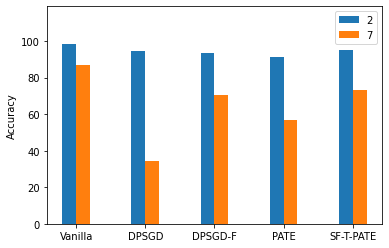

In [41]:
# model_names = ["Vanilla", "DPSGD", "Latent DPSGD-W", "DP-IS-SGD", "DPSGD-F", "PATE", "SF-T-PATE"]
model_names = ["Vanilla", "DPSGD", "DPSGD-F", "PATE", "SF-T-PATE"]
nums = [2, downsampled_num]
accuracies = {n: np.zeros(len(model_names)) for n in nums}
for i, model in enumerate(model_names):
    for n in nums:
        df_ = df_test[df_test["label"] == n]
        suffix = model.lower().replace("-", "").replace(" ", "")
        accuracies[n][i] = np.mean(df_[f"preds_{suffix}"] == df_["label"])

width = 0.2
ind = np.arange(len(model_names))
for i, n in enumerate(nums):
    plt.bar(ind + width * i, accuracies[n] * 100, width, label=str(n))

plt.ylabel("Accuracy")
plt.legend()
plt.xticks(ind + width * (len(nums) - 1) / 2, model_names)
plt.ylim(0, 119)
plt.show()

## Experiments

### DP-SGD Fairness

In [16]:
from google.colab import drive

drive.mount('/content/drive')

filename = "/content/drive/MyDrive/Thesis/DPSGD(MNIST).json"

experiments = {}
if os.path.exists(filename):
    with open(filename, 'r') as f:
        experiments = json.load(f)
        f.close()

test_labels = np.array(tuple(zip(*test_data))[1])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
def run_dpsgd_experiment(exp_id, *, epsilon, max_grad_norm, target_delta, epochs,
                         iters, classes, downsampled_nums, n_downsampled, 
                         logical_batch_size, max_physical_batch_size):
    if exp_id in experiments:
        return

    all_idxs = np.arange(len(train_data))
    all_downsampled_idxs = []
    downsampled_num_mask = np.zeros(len(all_idxs)).astype(bool)
    for n, downsampled_count in zip(downsampled_nums, n_downsampled):
        n_idxs = all_idxs[train_data.targets == n]
        downsampled_idxs = np.random.choice(n_idxs, downsampled_count, replace=False)
        all_downsampled_idxs.extend(downsampled_idxs)

        downsampled_num_mask |= (train_data.targets == n).numpy()

    rem_idxs = all_idxs[~downsampled_num_mask]

    idxs = np.concatenate((rem_idxs, all_downsampled_idxs))
    np.random.shuffle(idxs)
    downsampled_train_data = torch.utils.data.Subset(train_data, idxs)

    train_loader = torch.utils.data.DataLoader(
        downsampled_train_data,
        batch_size=logical_batch_size,
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=logical_batch_size,
        shuffle=False
    )

    sample_rate = 1 / len(train_loader)
    sigma = get_noise_multiplier(
        target_epsilon=epsilon,
        target_delta=target_delta,
        sample_rate=sample_rate,
        steps=int(epochs / sample_rate),
        accountant=RDPAccountant().mechanism(),
    )

    accs = {cls: [] for cls in classes}
    for i in range(iters):
        with io.capture_output():
            model, _ = pf.training.train_dpsgd(
                train_loader=train_loader,
                val_loader=None,
                model_class=VanillaCNN,
                optim_class=optim.NAdam,
                loss_fn=nn.NLLLoss(),
                target_epsilon=epsilon,
                target_delta=target_delta,
                max_grad_norm=max_grad_norm,
                epochs=epochs,
                max_physical_batch_size=max_physical_batch_size
            )
            preds = pf.utils.evaluate_model(model.to(device), test_loader, verbose=False)
            correct_mask = preds == test_labels
            for cls in classes:
                class_mask = cls == test_labels
                accs[cls].append(np.sum(correct_mask & class_mask) / np.sum(class_mask))

    experiments[exp_id] = {
        "classes": [],
        "means": [],
        "stds": [],
        "epsilon": epsilon,
        "sigma": sigma,
        "max_grad_norm": max_grad_norm,
        "sampling_rate": sample_rate,
        "delta": target_delta
    }

    for cls in classes:
        experiments[exp_id]["classes"].append(cls)
        experiments[exp_id]["means"].append(np.mean(accs[cls]))
        experiments[exp_id]["stds"].append(np.std(accs[cls]))

    with open(filename, 'w') as f:
        json.dump(experiments, f)
        f.close()

epsilons = [0.2, 0.5, 0.8, 1.0, 2.0, 5.0, 10.0, 50.0]

for epsilon in tqdm(epsilons):
    eps_id = f"eps={epsilon:.2f}"
    run_dpsgd_experiment(
        eps_id,
        epsilon=epsilon,
        max_grad_norm=1.2,
        target_delta=1e-5,
        epochs=10,
        iters=5,
        classes=list(range(10)),
        downsampled_nums=[8],
        n_downsampled=[500],
        logical_batch_size = 512,
        max_physical_batch_size = 256
    )

  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/opacus/accountants/analysis/rdp.py:333: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."
100%|██████████| 8/8 [47:13<00:00, 354.22s/it]


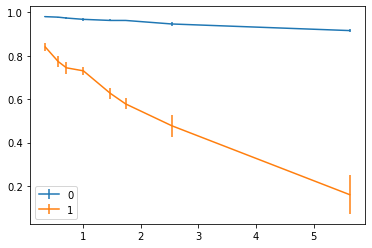

In [27]:
prefix = "eps="
epsilons = []
sigmas = []
means = defaultdict(list)
stds = defaultdict(list)
for key in experiments.keys():
    if key.startswith(prefix):
        val = experiments[key]
        for num, mean, std in zip(val["classes"], val["means"], val["stds"]):
            means[num].append(mean)
            stds[num].append(std)

        epsilons.append(val["epsilon"])
        sigmas.append(val["sigma"])

for cls in [2, 8]:
    plt.errorbar(x=sigmas, y=means[cls], yerr=stds[cls])

plt.legend([2, 8])
plt.show()

In [ ]:
grad_norms = [0.5, 0.8, 1.0, 1.2, 1.5, 1.8, 2.0, 2.5]

for grad_norm in tqdm(grad_norms):
    gn_id = f"grad_norm={grad_norm:.2f}"
    run_dpsgd_experiment(
        gn_id,
        epsilon=1.0,
        max_grad_norm=grad_norm,
        target_delta=1e-5,
        epochs=10,
        iters=5,
        classes=list(range(10)),
        downsampled_nums=[8],
        n_downsampled=[500],
        logical_batch_size = 512,
        max_physical_batch_size = 256
    )

### PATE Fairness

## Latex Plots

In [ ]:
!pip install folium==0.2.1
!pip install pdflatex
!pip install scienceplots
!sudo apt-get update
!sudo apt-get install texlive-latex-recommended 
!sudo apt install texlive-latex-extra
!sudo apt install dvipng

clear_output()

mpl.use("pgf")
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
})